In [1]:
# Toggle feature to hide code
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Using standards to shape privacy preserving behaviour in Bitcoin transactions: Measuring the effect of BIP32

                                                                    Daniel S. Rincón

## Privacy as a primitive for trust

Blockchains are emerging as a new system architecture paradignm for our information society that will allow us to automate and scale trust. The scaling of trust will represent lower transaction costs in everything from making everyday payments, to securely transfering assets, to increasing cooperation between people, organizations and nation states. 

They key innovation behid blockchain is the combination of economic incentives with [cryptographic] technology to enable a network of computers to share an information state without the need for a centralized authority or source of truth. An important application of this technology is the creation of value storage and transfer networks [cryptocurrencies] that allow people to transact without the need of an intermediary. Even though these networks are still slow and inefficient in comparisson to their centralized counterparts, their open nature will eventually allow them to become the underlying layer on top of which digital trust systems are built (credit, escrow, contracts, etc.). 

Bitcoin is the largest of these networks and although it doesn't provide the features of more recent ones, it has generated more significant network effects than any other, making it the strongest candidate to become the dominant player in this new digital stack. Nonetheless the inhability of Bitcoin to provide true privacy guarantees has hindered, amongst other factors, its ability to gain wider adoption.



 


### The blockchain oxymoron: public privacy

To make descentralized value transfer possible, Bitcoin introduced the idea of a public ledger. In order for Bob to certify ownership of the coins (value) that they want to transfer, there should be a public record that indicates that Bob previously received these coins from someone else and that he hasn't spent them. The 'block-chain' in bitcoin therefore refers to a data structure that keeps a public record of all transactions made, allowing all the participants to attest the validity of new transactions. 

Even though users transact in the Bitcoin network pseudonymously, using Bitcoin addresses which don't contain any personally identifiable information, transaction history remains public, and could eventually be used to compromise the privacy of individual or organizations transacting.

## BIP32: Enabling disposable identities

### Updating Bitcoin's Privacy: Shaping user behavior

The rules and specifications (protocol) under which the Bitcoin network operates are themselves mantained and updated in decentralized manner. The open source developer community that maintains the software which powers the network has to reach a consensus in order to make changes to the design. The way in which new feature ideas are proposed, discussed and implemented is trhough Bitcoin Improvement Proposals (BIPs).

Given the complexity of solving the problem of keeping a public transaction record while making transaction history private and the difficulty of reaching agreements within the developer community to make core changes to the protocol, Bitcoin Improvement Proposal 32 (BIP32) took a different approach and created a standard that helped people use addresses only once.

 

### Hierarchical Deterministic Wallets

By using addresses only once users could guarantee annonymity and avoid generating a persistent record of their transaction activity. Ideally users should generate a new address every time they are going to receive Bitcoins and share this address only with the entity they are receiving the funds from. Then, when they want to spend these coins they should create a transaction that moves all the coins out of the address (and stores any change in another newly created address). This way addresses would only be used once and transaction patterns are not exposed. 

This ideal mode of use becomes impractical for users dealing with multiple transactions, specially if incoming and outcoming transfers don't happen secuentally and a user has to keep track of multiple balances. Given this impracticallity since the early days of the network, people tend to reuse addresses, sacrificing their privacy. BIP32 introduces a standard to develop Hierarchical Deterministic Wallets (HDW) that allow people to generate addresses indefinitely from one seed in a deterministic way. BIP32 was intended to introduce a standard that was compliant with most Bitcoin clients and  simplified the management of multiple addresses so that users could transact in a trully anonymous way. 


**Hierarchical Deterministic Wallets**
![title](deterministic_wallet.png)
Source: https://ozanyurtseven.wordpress.com/2015/04/29/hierarchical-deterministic-wallets-bip0032bip0044-in-ruby/


BIP 32 was first added as a BIP on April 16 of 2013 and was promoted to a 'Final'(approved) status on Feb 1 2016. Nonetheless it was 'practically' implemented somewhere in between. In order to evaluate the impact that BIP32 has had on transaction privacy we're choosing February 1, 2014 as the 'introduction' date given that the libraries that implemented this standar in the most used programing languages (C++, Javascript, Python, Go, Ruby) were released in the second half of 2013 or in in early 2014 (details of the evolution of BIP32 can be found here: https://github.com/bitcoin/bips/commits/master?after=58e737617cc5efbc73c85bd4c89fce67d448b0c7+34&path%5B%5D=bip-0032.mediawiki)

## Collecting Bitcoin transaction Data

### Transactions and blocks

Trasactions in bitcoin have the following two essential components: inputs and outputs. A user creating a transaction adds as inputs, available balances (UTXOs- unspent previous transactions) from addresses which they control (via private keys). It also adds as outputs other Bitcoin public addresses and the amount it whishes to send to each one. The total available balance in the inputs must be greater (or equal) than the total amount to be transfered in the outputs. Any difference will be claimed by the miner as a transaction fee. 

In order to make a bitcoin transaction a user must broadcast the transaction to the network, where it will be picked up by transaction validators (miners), validated, aggregated with other transactions into a block and added to the public blockchain. Miners compete by iterating through millions (trillions) of numbers (nonce) until they find one that, combined with the previous block, generates a hash that is under a certain target value. The difficulty of the target value is set in a way that is proportional to the available compute power in the network so that a new block, registering multiple transactions is published on average every 10 minutes. 


### The block graph

Graph analysis has been extensively used in research to explore the structure of Blockchain networks. We've performed and extensive literature survey that can be found here (https://docs.google.com/document/d/1Py7zW-nfLiHyBgAfjD-0JY_eN_o0MNWV70NhnuDPg5M/edit). 

In order to understand transactions we propose defining a directed multigraph for every block, where each node is an address and an edge is created between two addresses if there is a transaction from one to the other. More precisely, because transactions are from groups of addresses (inputs) to other groups of addresses (outputs), an edge between address A and address B is created if address A is present as an input in a transaction where address B is present as an output. Given that a transaction doesn't specify the exact amount being transferred from each input address to each output address, we assume that each input is distributing its balance proportionatelly across the outputs. 


In [3]:
# Library Imports
import pandas as pd
import numpy as np
import math
import os
import pickle
import random
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import percentileofscore
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

### Old and New Addresses

Given that individual user behaviour is difficult to track and requires additional assumptions with respect to how addresses are clustered into users, we analyze the interactions between old and new Bitcoin addresses in every transaction round (block). 

Any partipant in the network can create a public-private key pair, derive a new Bitcoin address from it and control the funds associated with it, as long as they're in possesion of the private key. For every block published the addresses that transacted in that block can be categorized as new or old. We define as a new address, an address that is being used in that block for the first time and define it as old otherwise. Given that addresses are created without balance, they will first appear as an output for a transaction, but can appear in more than one transaction in the block where they were 'created'. 

***Under the ideal privacy usage assumptions discussed above, during every transaction round, that is to say in every block, all the transactions should be directed towards new address*** . The extent to which this is the case can be used as a direct indicator of how much are users re-using their addresses. For every block graph sampled we performed different network analysis and calculated statistics that help measure the way in which transactions between old and new addresses have evolved over time and the effect of BIP 32 on them. 



### Sampling the blockchain

Bitcoin was launched on January 2009 and by April 2019 over 570,000 blocks had been published. The span of our analysis covers the period between December 29 2010 (Block 100,000) and February 10 2018 (Block: 507,089) were we sampled 7,906 blocks out of the total 407,089 that were published. 

To collect Bitcoin Blockchain data we deployed an AWS instance running a full node of the Bitcoin Core client and using the Blockchain analys library BlockSci (https://github.com/citp/BlockSci) in conjuction with NetworkX (https://networkx.github.io/) created transaction graphs for every block. A sumary of the statistics calculated for every graph are shown below. 

In [15]:
# ---LOAD DATA AND CREATE DATAFRAME 
pd.reset_option('all', silent=True)
# Define constants
extraction_path='extractions/'
extraction_code='Urm0tw'
#introduction_block=395800 # Official update of status of BIP32 to Final Feb/2016
introduction_block=283470 # Introduction of major BIP32 clients
window_days=180
blocks_day=140
window_blocks=window_days*blocks_day # Window around discontinuity threshold
full_ext_name=""
directories = os.listdir(extraction_path)

# Find extraction directory given extraction code
for d in directories:
    if extraction_code in d:
        full_ext_name=d
assert full_ext_name!="",'There is no extraction with the given code'


# Create dataframe from stored .csv file
df=pd.read_csv(extraction_path+full_ext_name+'/'+full_ext_name+'.csv')
df=df.loc[df['block_height'] >100000]
df['value_transacted']=df['value_transacted']/100000000 # Change to units: Bitcoin
df['value_to_old']=df['value_to_old']/100000000
pd.options.display.float_format = '{:.2E}'.format
df.describe()


,block_height,no_nodes,no_edges,value_transacted,total_density,nodes_self,selfloop_value,old_nodes_in,ratio_oldin_totalin,value_to_old,old_density
count,7.91E+03,7.91E+03,7.91E+03,7.91E+03,7.91E+03,7.91E+03,7.91E+03,7.91E+03,7.91E+03,7.91E+03,7.91E+03
mean,3.01E+05,2.73E+03,6.75E+03,1.81E+04,7.03E-03,3.14E+02,9.12E+10,3.35E+03,4.63E-01,7.31E+03,6.95E-03
std,1.13E+05,3.11E+03,1.40E+04,1.16E+05,2.48E-02,5.47E+02,3.28E+11,1.10E+04,2.08E-01,4.46E+04,3.47E-02
min,1.00E+05,1.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00,0.00E+00
25%,2.05E+05,2.80E+02,4.34E+02,1.70E+03,4.28E-04,1.50E+01,1.76E+09,2.06E+02,3.21E-01,6.25E+02,3.91E-04
50%,2.87E+05,1.12E+03,2.47E+03,5.34E+03,1.87E-03,1.58E+02,1.81E+10,1.17E+03,4.60E-01,2.11E+03,1.44E-03
75%,4.01E+05,5.18E+03,1.05E+04,1.44E+04,5.38E-03,4.47E+02,7.51E+10,4.29E+03,6.06E-01,6.06E+03,5.03E-03
max,5.07E+05,2.31E+04,6.39E+05,5.23E+06,1.05E+00,3.31E+04,1.47E+13,5.38E+05,9.92E-01,2.01E+06,2.32E+00


## Measuring the evolution of privacy in the transaction graph

### Density of old address sub-graph

The density of a graph is the ratio between the number of edges and the maximum possible of edges given the number of nodes in the graph. Below we show the distribution of the density for the subgraph defined by all the old addreses transacting in blocks before and after the introduction of BIP32. After BIP32 the transaction density of old nodes is almost one order of magnitude less than before BIP32. This could be attributed both to less transactions between old nodes, but it could also be due to a larger network and therefore less relationships between existing nodes.  

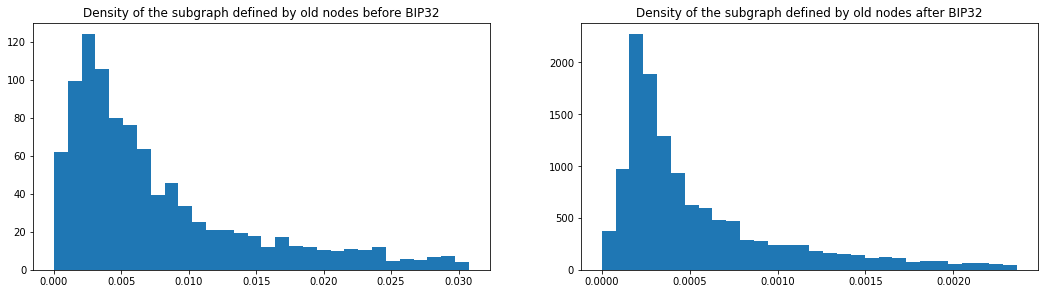

In [202]:
#DENSITY DISTRIBUTION

# Define dataframes for before and after BIP32 and remove outliers
df_before=df.loc[df['block_height']<introduction_block-window_blocks]
df_before_s=rem_outliers(df_before,'old_density',10)['old_density'] # Don't show top 10% of distribution

df_after=df.loc[df['block_height']>introduction_block+window_blocks]
df_after_s=rem_outliers(df_after,'old_density',10)['old_density']

# Plot density 
fig=plt.figure(figsize=(18,10))
ax1=fig.add_subplot(221)
ax1.hist(df_before_s, normed=True, bins=30)
ax1.title.set_text('Density of the subgraph defined by old nodes before BIP32')
ax2=plt.subplot(222)
ax2.hist(df_after_s, normed=True, bins=30)
ax2.title.set_text('Density of the subgraph defined by old nodes after BIP32')

plt.show()



The graphs below show incoming transactions to both old (blue) and new (red) addresses  for two sample blocks (one before BIP32 and one after), each of which has a density close to the median for its time period. It can be seen how, even though transactions between old addresses are prevalent after BIP32 the density of transactions to old addresses decreases, while it increases for new ones after the introduction of deterministic wallets. 

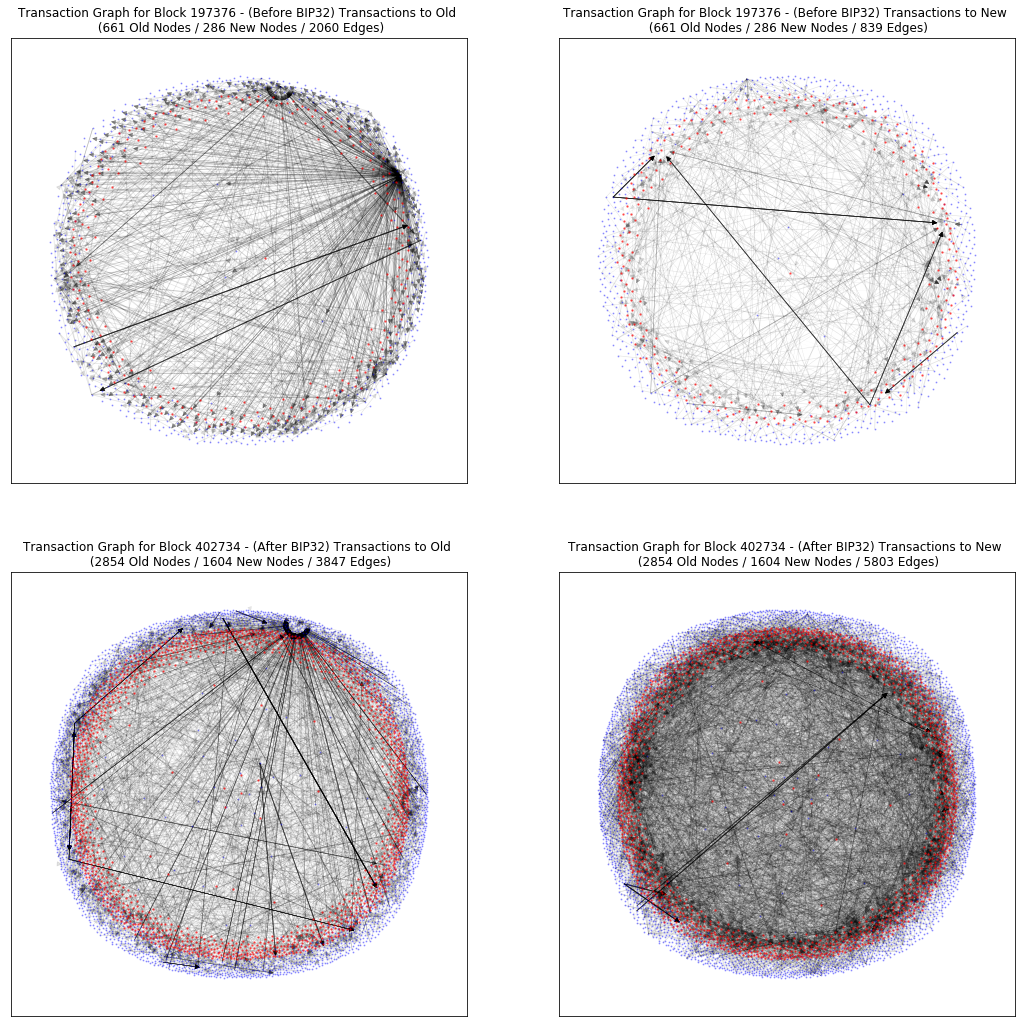

In [26]:
# DRAW SAMPLE TRANSACTION GRAPHS for blocks with median density befor and after BIP32

# Get graph files from extraction
graphs_path=extraction_path+full_ext_name+'/graphs/'
graph_files = os.listdir(graphs_path)

# Define range around the median
lower_percentile=48
upper_percentile=52
ax_pos=220
bip32='(Before BIP32)'


# Select sample block and corresponding graphs for before and after BIP32
bblock=block_in_range(df_before,'old_density',lower_percentile,upper_percentile)
Gb=nx.read_gpickle(graphs_path+str(int(bblock))+'.gpickle')
graphb_id=Gb.graph['graph_id']

ablock=block_in_range(df_after,'old_density',lower_percentile,upper_percentile)
Ga=nx.read_gpickle(graphs_path+str(int(ablock))+'.gpickle')
grapha_id=Ga.graph['graph_id']

Graphs=[Gb,Ga]
graph_ids=[graphb_id,grapha_id]

# Define plot and loop over before and after graph
fig=plt.figure(figsize=(18,18))
for G,graph_id in zip(Graphs,graph_ids):     
    
    
    # Title prefix
    if ax_pos>221:
        bip32='(After BIP32)'
    
    # Define nodes
    old_nodes = [n for (n,ty) in nx.get_node_attributes(G,'block_created').items() if ty < graph_id]
    new_nodes = list(set(G.nodes()) - set(old_nodes))


    # Define edges between old nodes and draw
    edges_to_old=[(u,v,d) for u,v,d in G.in_edges(old_nodes,data=True)]
    draw_2node_graph(fig,G,old_nodes,new_nodes,edges_to_old,'value',ax_pos+1,edge_type=bip32+' Transactions to Old')

    # Define edges between new nodes and draw
    edges_to_new=[(u,v,d) for u,v,d in G.in_edges(new_nodes,data=True)]
    draw_2node_graph(fig,G,old_nodes,new_nodes,edges_to_new,'value',ax_pos+2,edge_type=bip32+' Transactions to New')

    ax_pos+=2

plt.show()


### Value transacted to old addresses

Even though the transaction density decreased for old addresses in comparisson to new ones,  the total value transacted by old addresses seems to have increased after BIP32 was introduced as is shown below. 

In [16]:
# Calculate proportions of transaction volume
df_before=df.loc[df['block_height']<introduction_block]
df_after=df.loc[df['block_height']>introduction_block]

old_prop_b= df_before['value_to_old'].sum()/df_before['value_transacted'].sum()
new_prop_b=1-old_prop_b

old_prop_a= df_after['value_to_old'].sum()/df_after['value_transacted'].sum()
new_prop_a=1-old_prop_a

print('Proportion of value to old before BIP32: {:.3f}'.format(old_prop_b))
print('Proportion of value to new before BIP32: {:.3f}'.format(new_prop_b))
print('-------')
print('Proportion of value to old after BIP32: {:.3f}'.format(old_prop_a))
print('Proportion of value to new after BIP32: {:.3f}'.format(new_prop_a))


Proportion of value to old before BIP32: 0.323
Proportion of value to new before BIP32: 0.677
-------
Proportion of value to old after BIP32: 0.458
Proportion of value to new after BIP32: 0.542


<function matplotlib.pyplot.show>

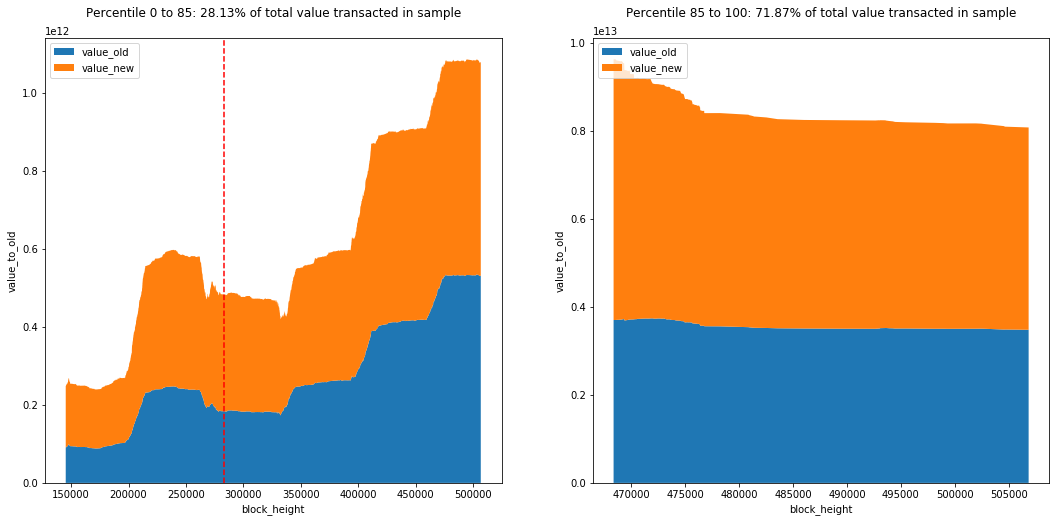

In [193]:
#---GRAPHS that show distribution of Transaction value to old and new addresses over time

# Define percentiles for 
df['value_per']=np.array([percentileofscore(df['value_transacted'].values,v,'rank') for v in df['value_transacted'].values])

# Define constants
fig=plt.figure(figsize=(18,18))
boundaries=[(0,85),(85,100)]
ax_pos=220

# Loop over percentile boundaries to create a graph for each boundary
for b in boundaries:
    
    total=df['value_transacted'].sum()
    # Create Data Frame
    df_trimmed_init=df.loc[((df['value_per']>b[0]) & (df['value_per']<=b[1])) ]
    df_trimmed=df_trimmed_init.sort_values('block_height')
    df_trimmed['value_transacted']= df_trimmed['value_transacted'].rolling(1000).mean()
    df_trimmed['value_to_old']= df_trimmed['value_to_old'].rolling(1000).mean()

    # Create stacked values
    value_old=df_trimmed['value_to_old'].values
    value_new=(df_trimmed['value_transacted']-df_trimmed['value_to_old']).values
    values=np.stack([value_old,value_new])
    block_heights=df_trimmed['block_height'].values

    # Plot figure
    ax=fig.add_subplot(ax_pos+1)
    plt.stackplot(block_heights,values,labels=['value_old','value_new'])
    plt.legend(loc='upper left')
    
    # Plot threshold line
    if b[0]<60:
        plt.axvline(x=introduction_block,color='red',linestyle='dashed')

    
    # Add title and axis
    percentage=(df_trimmed_init['value_transacted'].sum()/df['value_transacted'].sum())*100
    ax.title.set_text('Percentile {} to {}: {:.2f}% of total value transacted in sample\n'.format(b[0],b[1],percentage))
    ax.set_xlabel('block_height')
    ax.set_ylabel('value_to_old')
    
    
    ax_pos+=1


plt.show

## Effect of BIP32: Regression discontinuity approach

In order to evaluate the impact of BIP32 we performed regression discontinutiy analysis on 4 variables that mesured the privacy perserving transaction behaviours. We believe that assumptions of continuity around the BIP32 threshold are resonable because blocks around the event seem to have comparable characteristics. The selected variables were:  
- **old_density**: This measure indicates the density of the subgraph induced by old addresses for every block. 
- **value_to_old**: The total value transacted to old addresses for every block.
- **ration_oldin_totalin**: The ratio of transactions to old address to total transacitons for every block. 
- **nodes_self**: The number of address present in a block that transact with themselves. 


We apporoximated different polynomial models that explained the selected variable in terms of  block_height and the dicotomous variable (BIP32), which takes the value of 1 if BIP32 if block_height was greater than the height when deterministic wallets were introduced and 0 otherwise. For each variable we picked the model (highlighted in blues) that had the best fit and where BIP32 had statistical significance. 

In [23]:
# Script that fits different polynomial models to different running variables 

# Define variable, thresholds, windows and degrees to test
yname_list=['old_density','value_to_old','ratio_oldin_totalin','nodes_self']
xname_list=['block_height']*len(yname_list)
thresh_list=[introduction_block]*len(yname_list)
window_list=[window_blocks]*len(yname_list)
test_deg=[1,2,3,4,5]

variable=[]
degree=[]
r2=[]
effect=[]
p_value=[]


for var in yname_list: 
    for deg in test_deg:
        cols,x,y,model=pol_reg_dis(df,deg,var,'block_height',introduction_block)
        predictions=model.predict(x)
        r2_i=r2_score(np.array(y),np.array(predictions))
        effect_i=model.params[1]
        pvalue_i=model.pvalues[1]
        variable.append(var)
        degree.append(deg)
        r2.append(r2_i)
        effect.append(effect_i)
        p_value.append(pvalue_i)
    
# Create Dataframe
data=np.transpose(np.array([variable,degree,r2,effect,p_value]))
cols=['Variable','Polynomial Degree','r2','BIP32 coefficient','p_value']
df_r2=pd.DataFrame(data=data,columns=cols)

# Edit column formats
df_r2['r2'] = df_r2['r2'].astype(float).map('{:.2e}'.format)
df_r2['BIP32 coefficient'] = df_r2['BIP32 coefficient'].astype(float).map('{:.2e}'.format)
df_r2['p_value'] = df_r2['p_value'].astype(float).map('{:.2e}'.format)


# Color selected models: 
df_r2.style.apply(lambda x: ['background: lightblue' if x.name in [2,7,11,18] else '' for i in x],axis=1)




,Variable,Polynomial Degree,r2,BIP32 coefficient,p_value
0,old_density,1,3.09e-02,-7.95e-04,6.09e-01
1,old_density,2,3.43e-02,-2.56e-03,1.59e-01
2,old_density,3,3.37e-02,1.02e-11,4.59e-24
3,old_density,4,3.07e-02,1.12e-17,3.20e-03
4,old_density,5,1.79e-02,5.55e-22,3.75e-07
5,value_to_old,1,4.02e-03,5.30e+02,7.94e-01
6,value_to_old,2,1.27e-02,-9.63e+03,4.56e-05
7,value_to_old,3,1.23e-02,1.41e-05,7.29e-27
8,value_to_old,4,1.36e-02,2.85e-11,7.01e-09
9,value_to_old,5,6.88e-03,-6.05e-16,1.85e-05


As seen above only two variables (**ratio_oldin_totalin** and **nodes_self**) have models with resonable good fits ($r^2>0.1$) and only **ratio_oldin_totalin** has a BIP32 coefficient of practical significance. In particular, the quadratic model for **ratio_oldin_totalin** estimates that BIP32 generated a decrease of 0.35 in the proportion of transactions to old address over all transactions. This finding is significant given that the proportion of transactions to old addresse over all transactions was on average around 0.70 before the introduction of BIP32.

The graphical regression discontinuty analysis for the selected models is shown below. A window of 180 days before and after block 283,470 was used to estimate the models before and after BIP32.

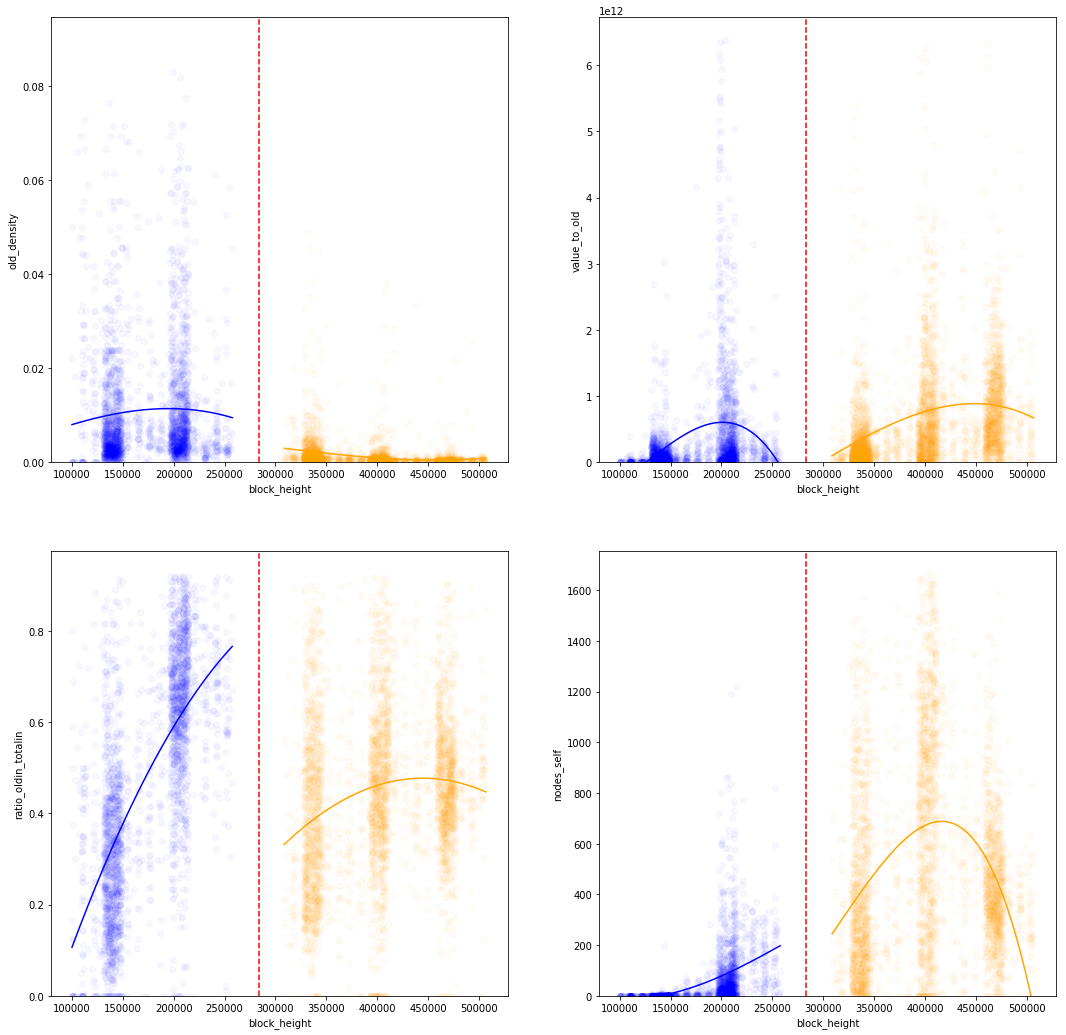

In [101]:
#---PLOT  regression discontinuity graphs for selected models

deg_list=[3,3,2,4] # Selected polynomial degrees
reg_dis_graph(df,deg_list,xname_list,yname_list,thresh_list,window_list) #See function specification below



## Conclusions 

The above analysis shows that by some accounts the introducton of a standard for Deterministic Hierarchical Wallets in BIP32 did have an impact on making transaction behaviour more private. Nonetheless even though the data seems to support that users started re-using addresses less after the standard was introduced, the addresses being reused are transacting a significant proportion of the value in the Bitcoin network. It is evident that beyond the improvement generated by BIP32 the trend of adopting better privacy transaction behaviour has stagnated and a significant amount of addresses is still being reused even as late as recently as 2018. Future work should attempt to further understand and characterize this segment of the network that is not adopting privacy perserving practices determine the barries that are preventing them from adopting better practices and inform future protocol design. 

## References

- Akcora, C.G., Gel, Y.R., & Kantarcioglu, M. (2017). Blockchain: A Graph Primer. CoRR, abs/1708.08749.
- Alvarez-Pereira, B., Ayres, M.R., Lopez, A.M., Gorsky, S., Hayes, S., Qiao, Z., & Santana, J. Network and Conversation Analyses of Bitcoin.
- Bartoletti, Massimo & Lande, Stefano & Pompianu, Livio & Bracciali, Andrea. (2017). A general framework for blockchain analytics. 1-6. 10.1145/3152824.3152831. 
- Maesa, Damiano & Marino, Andrea & Ricci, Laura. (2016). Uncovering the Bitcoin Blockchain: An Analysis of the Full Users Graph. 537-546. 10.1109/DSAA.2016.52. 
- Baumann, Annika & Fabian, Benjamin & Lischke, Matthias. (2014). Exploring the Bitcoin Network. WEBIST 2014 - Proceedings of the 10th International Conference on Web Information Systems and Technologies. 1. 10.5220/0004937303690374. 
- Bob, Bob, A., Alice, B., Alice, & Carol, A. (2017). Anonymous Alone ? Measuring Bitcoin ’ s Second-Generation Anonymization Techniques.
- Cachin, C., Caro, A.D., Moreno-Sanchez, P., Tackmann, B., & Vukolic, M. (2017). The Transaction Graph for Modeling Blockchain Semantics. IACR Cryptology ePrint Archive, 2017, 1070.
- Cazabet, R., Rym, B., & Latapy, M. (2017). Tracking bitcoin users activity using community detection on a network of weak signals. COMPLEX NETWORKS.
- Fleder, Michael & S. Kester, Michael & Pillai, Sudeep. (2015). Bitcoin Transaction Graph Analysis. 
- Harlev, M.A., Yin, H.S., Langenheldt, K.C., Mukkamala, R.R., & Vatrapu, R. (2018). Breaking Bad: De-Anonymising Entity Types on the Bitcoin Blockchain Using Supervised Machine Learning. HICSS.
- Harrigan, M., & Fretter, C. (2016). The Unreasonable Effectiveness of Address Clustering. 2016 Intl IEEE Conferences on Ubiquitous Intelligence & Computing, Advanced and Trusted Computing, Scalable Computing and Communications, Cloud and Big Data Computing, Internet of People, and Smart World Congress (UIC/ATC/ScalCom/CBDCom/IoP/SmartWorld), 368-373.
- Jawaheri, H.A., Sabah, M.A., Boshmaf, Y., & Erbad, A. (2018). When A Small Leak Sinks A Great Ship: Deanonymizing Tor Hidden Service Users Through Bitcoin Transactions Analysis. CoRR, abs/1801.07501.
- Jourdan, M., Blandin, S., Wynter, L., & Deshpande, P. (2018). Characterizing Entities in the Bitcoin Blockchain. CoRR, abs/1810.11956.
- Kalodner, H.A., Goldfeder, S., Chator, A., Möser, M., & Narayanan, A. (2017). BlockSci: Design and applications of a blockchain analysis platform. CoRR, abs/1709.02489.
- Kondor D, Pósfai M, Csabai I, Vattay G (2014) Do the Rich Get Richer? An Empirical Analysis of the Bitcoin Transaction Network. PLoS ONE 9(2): e86197. https://doi.org/10.1371/journal.pone.0086197
- Lischke, Matthias & Fabian, Benjamin. (2016). Analyzing the Bitcoin Network: The First Four Years. Future Internet. 8. 10.3390/fi8010007. 
- Maesa, Damiano & Marino, Andrea & Ricci, Laura. (2017). Data-driven analysis of Bitcoin properties: exploiting the users graph. International Journal of Data Science and Analytics. 10.1007/s41060-017-0074-x. 
- Marc Ortega. The Bitcoin Transaction Graph—Anonymity. Master’s the- sis, Universitat Oberta de Catalunya, 6 2013.
- McGinn, D., McIlwraith, D., & Guo, Y. (2018). Towards open data blockchain analytics: a Bitcoin perspective. Royal Society open science.
- Monaco, Vinnie. (2015). Identifying Bitcoin users by transaction behavior. 10.1117/12.2177039. 
- Neudecker, T., & Hartenstein, H. (2017). Could Network Information Facilitate Address Clustering in Bitcoin? Financial Cryptography Workshops.
- Nick, J.D. (2015). Data-Driven De-Anonymization in Bitcoin
- Ober, M., Katzenbeisser, S., & Hamacher, K. (2013). Structure and Anonymity of the Bitcoin Transaction Graph. Future Internet, 5, 237-250.
- Paquet-Clouston, M., Haslhofer, B., & Dupont, B. (2018). Ransomware Payments in the Bitcoin Ecosystem. CoRR, abs/1804.04080.
- Pompianu, Livio & Bartoletti, Massimo & Bellomy, Bryn. (2019). A Journey into Bitcoin Metadata. Journal of Grid Computing. 10.1007/s10723-019-09473-3. 
- Ranshous, S., Joslyn, C., Kreyling, S., Nowak, K., Samatova, N.F., West, C.L., & Winters, S. (2017). Exchange Pattern Mining in the Bitcoin Transaction Directed Hypergraph. Financial Cryptography Workshops.
- Reid, Fergal & Harrigan, Martin. (2011). An Analysis of Anonymity in the Bitcoin System. Security and Privacy in Social Networks. 3. 10.1109/PASSAT/SocialCom.2011.79. 
- Ron D., Shamir A. (2013) Quantitative Analysis of the Full Bitcoin Transaction Graph. In: - Sadeghi AR. (eds) Financial Cryptography and Data Security. FC 2013. Lecture Notes in Computer Science, vol 7859. Springer, Berlin, Heidelberg
- SARAHMEIKLEJOH, N., MARJORIPOMAROL, E., G R A N T J O R D A N, K.I., GEOFFR, E., & YMVOELKERANDSTEFANSAV, A. (2013). A Fistful of Bitcoins Characterizing Payments Among Men with No Names.
- Spagnuolo, Michele & Maggi, Federico & Zanero, Stefano. (2014). BitIodine: Extracting Intelligence from the Bitcoin Network. 8437. 457-468. 10.1007/978-3-662-45472-5_29. 
- Yue, X., Shu, X., Zhu, X., Du, X., Yu, Z., Papadopoulos, D., & Liu, S. (2018). BitExTract: Interactive Visualization for Extracting Bitcoin Exchange Intelligence. IEEE Transactions on Visualization and Computer Graphics, 25, 162-171.

## Appendix: Functions

In [17]:
# Function to plot regression discontinuties graphs for different (x,y) variables

def reg_dis_graph(df_0,deg_list,xname_list,yname_list,thresh_list,window_list):
    
    no_columns=2
    no_rows=math.ceil(len(deg_list)/no_columns)
    fig, axs = plt.subplots(no_rows,no_columns)
    axs = axs.flatten()
    fig.set_figheight(18)
    fig.set_figwidth(18)
    graph_pos=0
    
    for deg,x_name,y_name,thresh,window in zip(deg_list,xname_list,yname_list,thresh_list,window_list):
        
        
        
        df_i=rem_outliers(df_0,y_name,1)
        # Define row and column for plot
        column=graph_pos//no_columns
        row=graph_pos%no_columns
        
        # Before polynomial model and graph
        # Get predictions
        df_before=df_i.loc[df[x_name]<thresh-window]
        xb,poly_xb,model_b=pol_reg(df_before,deg,y_name,x_name)
        predictions_b=model_b.predict(poly_xb)
        # Plot points and line before threshold 
        sns.regplot(x=x_name, y=y_name, fit_reg=False, data=df_before,color='blue', ax=axs[graph_pos],scatter_kws={'alpha':0.03})
        sns.lineplot(x=xb,y=predictions_b,ax=axs[graph_pos],color='blue')
        
        # After polynomial model and graph
        # Get predictions
        df_after=df_i.loc[df[x_name]>thresh+window]
        xa,poly_xa,model_a=pol_reg(df_after,deg,y_name,x_name)
        predictions_a=model_a.predict(poly_xa)
         # Plot points and line before threshold 
        sns.regplot(x=x_name, y=y_name, fit_reg=False, data=df_after,color='orange', ax=axs[graph_pos],scatter_kws={'alpha':0.03})
        sns.lineplot(x=xa,y=predictions_a,ax=axs[graph_pos],color='orange')
        
        # Plot threshold line
        axs[graph_pos].axvline(x=thresh,color='red',linestyle='dashed')
        axs[graph_pos].set_ylim(ymin=0) #adjuts y_limt
        graph_pos+=1

        
    return

In [18]:
# Function to perform non-linear (polynomial) regression discontinuity estimation 

def pol_reg_dis(df_i,deg,y_name,x_name,threshold):
    
    
    # Copy dataframe 
    df_c=df_i.copy()
    
    # Recode variables and define regression data
    df_c['treatment']=np.where(df_c[x_name]>threshold,1,0)
    df_c['x_cen']=df_c[x_name]-threshold
    y=df_c[y_name].values
    x=df_c[['treatment','x_cen']].values

    # Create new data frame for regression with interaction columns
    # Create non-linear interactions
    poly = PolynomialFeatures(degree = deg)
    poly_x=poly.fit_transform(x)
    feat_names=poly.get_feature_names(['treatment','x_cen'])
    
    # Create temporary dataframe to edit unwanted interactions
    df_reg=pd.DataFrame(poly_x,columns=feat_names)

    for col in df_reg.columns:
        if 'treatment^' in col:
            df_reg=df_reg.drop(columns=col)

    # Re-define x with pruned interactions
    x=df_reg.values
    cols=df_reg.columns

    # Fit lienar model 
    model=sm.OLS(y, x).fit()
    #model.summary(xname=list(df_reg.columns))
    
    return cols,x,y,model

In [19]:
# Function to perform single variable polynomial regression 

def pol_reg(df_i,deg,y_name,x_name):
    
    poly = PolynomialFeatures(degree = deg)
    x_0=df_i[x_name].values
    x=x_0.reshape(-1,1)
    poly_x=poly.fit_transform(x)
    y=df_i[y_name].values
    model=sm.OLS(y, poly_x).fit()
    
    return x_0,poly_x,model

In [20]:
# Function to remove outliers from a column in dataframes and return new dataframe

def rem_outliers(df_0,c,top):

    df_c=df_0.copy()
    df_c['value_per']=np.array([percentileofscore(df_0[c].values,v,'rank') for v in df_0[c].values])
    df_trimmed=df_c.loc[(df_c['value_per']<100-top)]

    return df_trimmed
        
        

In [25]:
# Function to extract the block with the most transactions for a variables percentage range

def block_in_range(df_0,variable,lower_percentile,upper_percentile,max_nodes=10000):

    df_temp=df_0.copy()
    
    # Define uper and lower percentiles 
    variable_list=df_temp[variable].tolist()
    lower=np.percentile(variable_list,lower_percentile,interpolation='nearest')
    upper=np.percentile(variable_list,upper_percentile,interpolation='nearest')

    # Sort temp dataframe and select the graph with the most edges (transactions)
    df_temp=df_temp.loc[(df_temp[variable]>lower) & (df_temp[variable]<upper) & (df_temp['no_edges']<max_nodes) ] #Limit size of graph
    df_temp=df_temp.sort_values('no_edges',ascending=False)
    block=df_temp['block_height'].iloc[5]
    
    return block


In [22]:
#Function that plots a network graph from two lists of nodes, one list of edges and a variable to define edge width

def draw_2node_graph(fig,G,nodes_1,nodes_2,edges,edge_width_v,subplot_q,edge_type=''):

    # Sample a max of 5000 edges to reduce plotting time and increase visibility
    init_edges=len(edges)
    #if init_edges>max_sample:
    #   edges=random.sample(edges, max_sample)
    trimmed_edges=len(edges)
    
    # Define circular layout 
    pos_o=nx.spring_layout(nodes_1, scale=1)
    pos_n=nx.spring_layout(nodes_2, scale=0.9)
    total_pos=pos_o
    total_pos.update(pos_n)


    # Define transactions to show (incoming edges)

    values=np.array([d[edge_width_v] for _,_,d in edges])
    max_value=np.max(values)
    values=values/max_value
    values_per=np.array([percentileofscore(values,v,'rank') for v in values])/100

    
    # Draw nodes and edges
    ax=fig.add_subplot(subplot_q)
    ax.title.set_text('Transaction Graph for Block {} - {} \n ({} Old Nodes / {} New Nodes / {} Edges)'.
                      format(G.graph['graph_id'],edge_type,len(nodes_1),len(nodes_2),init_edges))
    nx.draw_networkx_nodes(G, total_pos, nodelist=nodes_1, node_size=1, node_color='blue', alpha=0.3)
    nx.draw_networkx_nodes(G, total_pos, nodelist=nodes_2, node_size=2, node_color='red', alpha=0.5)
    nx.draw_networkx_edges(G,total_pos,edgelist=edges,alpha=0.1,width=values_per)
    
    return


In [ ]:
# Future improvements
#TODO: Create general graph function that given list of nodes, 